# 학습 데이터 불러오는 과정 훑어보기

In [ ]:
import os
import json

베이스라인 코드를 이해하는데 어려움이 있으신 캠퍼분들이 있을거 같아 주말동안 이해해 본 학습 데이터를 불러오는 과정을 한번 정리해봤습니다!

먼저 이번 MRC대회 특성상 (Retrieval, Reader)두가지 데이터셋을 불러와야합니다. 먼저 Retrieval을 하기위한 데이터를 불러와볼까요?

Retrieval을 위한 데이터는 ./data/wikipedia_documents.json파일에 저장되어 있어요

## 1. Retrieval를 이해해보자!

In [ ]:
data_path  = "../../data/"
context_path = "wikipedia_documents.json"

In [ ]:
with open(os.path.join(data_path, context_path), "r", encoding="utf-8") as f:
    wiki = json.load(f)

contexts = list(dict.fromkeys([v["text"] for v in wiki.values()]))
print('context len :', len(contexts))

wikipedia_documents 파일에 56737개의 문서가 존재하네요! 베이스라인 코드에서는 이 문서들을  TfidfVectorizer를 활용해 Sparse Embedding 벡터를 생성하고 있어요. 특징을 보면 ngram을 1으로 설정하고 최대 벡터의 크기를 50000으로 정하고 있습니다.

In [ ]:
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

MODEL_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

tfidfv = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 2))#, max_features=50000)
p_embedding = tfidfv.fit_transform(contexts)

p_embedding이 전체 문서에 대해 tf-idf를 계산한 벡터라고 생각하면 됩니다! 
동일한 데이터로 실행되는 tf-idf 벡터는 매번 같기때문에 베이스라인 코드에서는 pickle을 이용해 저장하고 불러와서 사용하고 있어요. (계산 실행시 4분정도 소요 됩니다..) 여기서는 직접 불러오서 데이터를 한번 봐볼게요.

In [ ]:
print('p_embedding.shape:', p_embedding.shape)
print('p_embedding[0] :', p_embedding[0])

In [ ]:
p_embedding[0]

데이터에서 볼수 있듯이 전체 문서 56737개에 대한 벡터를 생성한걸 볼수 있고, 각 벡터는 최대 50000개의 feature벡터에 [0]번 벡터의 경우 207개 밖에 데이터가 없을정도로 Sparse한 벡터인걸 볼수 있어요.

간단히 Retrieval을 이해하기위해 베이스라인에서 쿼리를 가져와봤어요! 쿼리벡터와 나머지 문서 56737개에 대해 dot product를 계산하면 가장 유사한 문서를 찾아낼 수 있지 않을까요?

In [ ]:
query = "대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?"

query_vec = tfidfv.transform([query])
query_vec

In [ ]:
result = query_vec * p_embedding.T
result = result.toarray()
print('result.shape: ', result.shape)

dot product를 활용해 쿼리와 각 문서간의 similariry ranking벡터를 구했어요! 이 벡터를 높은순으로 정렬해볼까요!
np.argsort함수를 활용해 유사도가 높은 문서의 index벡터를 만들어 볼게요

In [ ]:
import numpy as np

sorted_result = np.argsort(result.squeeze())[::-1]
sorted_result

52322번 문서가 가장 유사도가 높다고 하네요. 여기서 topk-3개까지 점수와 문서번호를 확인해볼게요!

In [ ]:
k=10
doc_scores = result.squeeze()[sorted_result].tolist()[:k]
doc_indices = sorted_result.tolist()[:k]
print('doc_score: ',doc_scores)
print('doc_indices: ', doc_indices)

In [ ]:
tokenizer.tokenize(query)

In [ ]:
print('query: ',query)

for i in range(k):
    print(f"Top-{i+1} passage with score {doc_scores[i]:4f}")
    print(contexts[doc_indices[i]])


나름 유사해보는 passage를 찾았지만 아쉽게도 학습데이터에서 주어진 passage를 찾지 못했어요. Dense Retrieval 을 적용해본다면 좋을 결과를 나오게 할수도 있을거 같아요! 실제 주어진 passage는 아래에서 MRC데이터를 뜯어보며 확인해봐요!

## 2. MRC 데이터셋 뜯어보기

In [ ]:
from datasets import load_from_disk
data = load_from_disk('../../data/train_dataset')

In [ ]:
data['train']

In [ ]:
data['train'][0]['question']

In [ ]:
data['train'][0]['document_id']

In [ ]:
data['train'][0]

In [ ]:
np.array(contexts)[doc_indices]

In [ ]:
contexts[doc_indices]

In [53]:
def origin_topk(query_vec, k):
    result = query_vec * p_embedding.T
    result = result.toarray()
    sorted_result = np.argsort(result.squeeze())[::-1]
    
    doc_scores = result.squeeze()[sorted_result].tolist()[:k]
    doc_indices = sorted_result.tolist()[:k]
    return doc_scores, doc_indices 

In [76]:
def get_topk_similarity(qeury_vec, k):
    result = query_vec * p_embedding.T
    result = result.toarray()

    doc_scores3 = np.partition(result, -k)[:, -k:][:, ::-1]
    ind = np.argsort(doc_scores3, axis=-1)[:, ::-1]
    doc_scores3 = np.sort(doc_scores3, axis=-1)[:, ::-1]
    doc_indices3 = np.argpartition(result, -k)[:, -k:][:, ::-1]
    r, c = ind.shape
    ind = ind + np.tile(np.arange(r).reshape(-1, 1), (1, c)) * c
    doc_indices3 = doc_indices3.ravel()[ind].reshape(r, c)

    return doc_scores3, doc_indices3

In [81]:
topk_loc = []
for i in range(len(data['train'])):
    query = data['train'][0]['question']
    query_vec = tfidfv.transform([query])
    
    k=20
    doc_scores, doc_indices = get_topk_similarity(query_vec, k)
    print(doc_indices)
    print(data['train']['document_id'][0])
    break

[[52322   268  1738  4879 30647  2269 22749 20097 14489  6795 15321 38020
  51907 52805 33053 20771 26618 24361 29710 20837]]
18293


In [85]:
data['train'][0]

{'title': '미국 상원',
 'context': '미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국 의회의 상원이다.\\n\\n미국 부통령이 상원의장이 된다. 각 주당 2명의 상원의원이 선출되어 100명의 상원의원으로 구성되어 있다. 임기는 6년이며, 2년마다 50개주 중 1/3씩 상원의원을 새로 선출하여 연방에 보낸다.\\n\\n미국 상원은 미국 하원과는 다르게 미국 대통령을 수반으로 하는 미국 연방 행정부에 각종 동의를 하는 기관이다. 하원이 세금과 경제에 대한 권한, 대통령을 포함한 대다수의 공무원을 파면할 권한을 갖고 있는 국민을 대표하는 기관인 반면 상원은 미국의 주를 대표한다. 즉 캘리포니아주, 일리노이주 같이 주 정부와 주 의회를 대표하는 기관이다. 그로 인하여 군대의 파병, 관료의 임명에 대한 동의, 외국 조약에 대한 승인 등 신속을 요하는 권한은 모두 상원에게만 있다. 그리고 하원에 대한 견제 역할(하원의 법안을 거부할 권한 등)을 담당한다. 2년의 임기로 인하여 급진적일 수밖에 없는 하원은 지나치게 급진적인 법안을 만들기 쉽다. 대표적인 예로 건강보험 개혁 당시 하원이 미국 연방 행정부에게 퍼블릭 옵션(공공건강보험기관)의 조항이 있는 반면 상원의 경우 하원안이 지나치게 세금이 많이 든다는 이유로 퍼블릭 옵션 조항을 제외하고 비영리건강보험기관이나 보험회사가 담당하도록 한 것이다. 이 경우처럼 상원은 하원이나 내각책임제가 빠지기 쉬운 국가들의 국회처럼 걸핏하면 발생하는 의회의 비정상적인 사태를 방지하는 기관이다. 상원은 급박한 처리사항의 경우가 아니면 법안을 먼저 내는 경우가 드물고 하원이 만든 법안을 수정하여 다시 하원에 되돌려보낸다. 이러한 방식으로 단원제가 빠지기 쉬운 함정을 미리 방지하는 것이다.날짜=2017-02-05',
 'question': '대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?',
 'id': 'mrc-1-000067',
 'answers': {'answer_start'

In [84]:
contexts[52322]

'국회에 관해 규정하는 헌법 제4장의 첫 조문이다.\n\n본조에서 말하는 "국권"이란 국가가 갖는 지배권을 포괄적으로 나타내는 국가 권력, 곧 국가의 통치권을 의미한다. 국권은 일반적으로 입법권·행정권·사법권의 3권으로 분류되지만, 그 중에서도 주권자인 국민의 의사를 직접 반영하는 기관으로서 국회를 "최고 기관"으로 규정한 것이다. 다만, 최고 기관이라 해서 타 기관의 감시와 통제를 받지 않는 것은 아니며 권력 분립 원칙에 따라 국회에 대한 행정권, 사법권의 견제를 받는다.\n\n또한 일본 전체 국민을 대표하는 기관을 국회로 규정함으로써, 국회는 일본의 유일한 입법 기관의 지위를 가지고 있다. 일본 제국 헌법 하에서 입법권은 천황의 권한에 속했으며, 제국의회는 천황의 입법 행위를 보좌하는 기관에 불과했다.\n\n여기서 "유일한 입법 기관"의 의미로는 다음과 같은 해석이 있다.\n* 국회 중심 입법 원칙 : 국회가 국가의 입법권을 독점한다는 원칙\n* 국회 단독 입법 원칙 : 국회의 입법은 다른 기관의 간섭 없이 이루어진다는 원칙\n\n또한 국회의 입법에 벗어나지 않는 범위 내에서 행정 기관은 정령 등의 규칙 제정권을 가지며(헌법 제73조 제6호), 최고재판소는 소송에 관한 절차, 변호사 및 재판소에 관한 내부 규율 및 사법 사무 처리에 관한 사항에 대한 규칙 제정권(헌법 제77조 제1항)을 가진다.'

In [79]:
data['train'][0:2]['question']

['대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?', '현대적 인사조직관리의 시발점이 된 책은?']

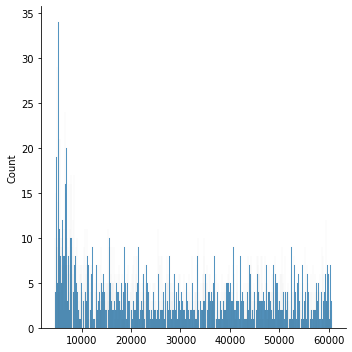

In [90]:
import seaborn as sns
sns.displot(data['train']['document_id'], binwidth=50)

In [87]:
contexts[18293]

'세인트조지역은 개통 이후 몇 차례 개편 공사에 들어간 바가 있다. 이 역의 버스 터미널 절반은 사용하지 않는 관계로 폐쇄된 상태이지만 나머지 터미널에 보수 작업이 들어갈 경우를 대비해 유지·보수 작업은 하고 있는 상태이다 현재 이 버스 터미널은 26번 듀폰트 버스만 이용하고 있다. 토론토 교통국은 또한 토론토 대학교가 블루어 스트리트 웨스트 252번지에 온타리오 교육 연구 학교 (OISE) 를 개장할 때 베드퍼드 애비뉴 대합실로 이어지는 무인 자동 출입구를 개통하였으며 1999년 7월 27일에는 베드퍼드 출입구에서 대합실, 버스 승강장 남쪽과 지하철 승강장을 잇는 엘리베이터를 설치하여 교통 약자들이 손쉽게 이용할 수 있게 되었다\\n\\n1993년, 세인트조지역은 베이와 스파다이나역과 더불어 폴 아서가 디자인한 새로운 간판이 설치된 시범역으로 선정되었는데, 이 간판은 노선색으로 노선을 알리고 그 역에 맞는 특별한 아이콘을 입혔다 세인트조지역의 아이콘은 세인트조지와 용에 관한 옛날 전설을 살려 TTC 실드에 용 문양을 덧붙였다. 이 새로운 간판은 완전히 도입되지 않았지만 초기 시범 간판이 2014년까지 그대로 남아있었다. 2016년, 세인트앤드루와 요크밀스역에 새로운 에나멜 금속 벽 커버가 호응을 얻으면서 에나멜 금속 패널이 승강장 벽 한 쪽에 설치되었다\\n\\n세인트조지역은 토론토 대학교와 가깝지만 대부분의 승객들은 세인트조지역에서 오랜 시간을 보내지 않는다. 버시티 경기장은 2001년에 문을 닫았고 이후 더 자그마한 경기장을 위해 철거되었다 이 역에서 내리는 대부분의 승객들은 환승객들로 지하철 두 노선이 최대 5분 간격으로 운행하기 때문에 심지어는 유니언역보다도 더 많은 승객을 수용할 수 있다. 2018년 1월 현재 세인트조지역은 별다른 리모델링 계획이 없으며 TTC 측은 이후 장기적으로 늘어나는 승객 수는 다운타운 릴리프 선이 해결할 수 있을 거라 믿고 있다'


# 3. Eval Set 둘러보기

In [91]:
from datasets import load_from_disk
test_data = load_from_disk('../../data/test_dataset')

In [92]:
test_data

DatasetDict({
    validation: Dataset({
        features: ['id', 'question'],
        num_rows: 600
    })
})

In [95]:
test_data['validation']['question']

["유령'은 어느 행성에서 지구로 왔는가?",
 '용병회사의 경기가 좋아진 것은 무엇이 끝난 이후부터인가?',
 '돌푸스에게 불특정 기간동안 하원이 잠시 쉬는 것을 건의 받았던 인물은?',
 '마오리언어와 영어, 뉴질랜드 수화를 공식 언어로 사용하는 나라는?',
 '디엔비엔푸 전투에서 보응우옌잡이 상대한 국가는?',
 '단공류가 일반 포유류와 다르다는 것을 알 수 있는 신체 부위는?',
 '상류 부르주아의 정치 독점을 불러일으킨 체계는?',
 '아시노 호가 만들어진 원인은 무엇인가?',
 '흉년이 발생하고 곳곳에 난이 일어났던 시기는?',
 '급전궤도는 보통 무엇으로 만들어져 있는가?',
 '클레어에게 오세아닉 815편을 타라고 말한 사람의 이름은?',
 '제6군이 18일 동안이나 대기해야 했던 장소는?',
 '누가 시장으로 선출되면서 트랜짓 시티 계획안이 불발되었나?',
 '1차 대각성 운동이 일어나는데 큰 영향을 끼친 설교는 어디서 진행되었는가?',
 '괴수로부터 메구밍을 구해준 사람은 누구인가?',
 '슈파이어 대성당 2차 축조시에 가장 우선순위로 고려했던 천장 건축 방식은?',
 '통대를 뽑을 수 있었던 주체는 누구인가?',
 '이유립씨가 1970년대 중반에 본인의 글을 기고하기 시작한 곳은?',
 '미군이 충원되지 않으면 서울이 전쟁 시작 후 2주만에 함락될 것이라 밝힌 문서는?',
 '임경업 장군이 도를 닦은 곳으로 알려진 곳은?',
 '화재에서 인종을 구한 공으로 귀인으로 직위가 오른 사람은?',
 '초등학생 일기검사의 인권침해 여부를 판단하는 주체는?',
 '콘스탄티누스가 군사 4만 명을 이끌고 침범한 나라는?',
 '불보살이 천도할 대상은?',
 '루돌로지스트들이 게임에서 가장 주된 것이라 주장하는 것은?',
 '조조에게 신고한 사람도 조사해야한다고 한 것은 누구인가?',
 '나카무라 번이 메이지 정부에 굴복하게 된 결투의 이름은 무엇인가요?',
 '펌프가 발매된 해는 언제인가?',
 '밀러허긴스가 법학을 전공한 곳은?',
 '유달산에서 다도해